In [ ]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns


# Replace with your actual folder paths
adata1 = sc.read_h5ad("Preprocess_data/10XGenomics_counts_adata.h5ad") #10x Genomics
adata2 = sc.read_h5ad("Preprocess_data/vasa-seq_counts_adata.h5ad") #VASA-seq
adata3 = sc.read_h5ad("SSTX_counts_adata_nomiRNA.h5ad") #TotalX
adata4 = sc.read_h5ad("SSTX_counts_adata_noDASH.h5ad") #TotalX miRNA(+)/DASH(-)
adata5 = sc.read_h5ad("Preprocess_data/SSTX_counts_adata_2XDASH.h5ad") #TotalX miRNA(+)/DASH(++)

/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [2]:
titles = ["10XGenomics",  "VASA-seq", "TotalX", "TotalX miRNA(+)/DASH(-)", "TotalX miRNA(+)/DASH(++)"]

# Put all objects in a list
adata_list = [adata1,  adata2, adata3, adata4, adata5]

In [3]:
# get the stats
for i, adata in enumerate(adata_list):
    # Compute total UMIs (or reads) per cell
    total_counts = np.array(adata.X.sum(axis=1)).flatten()  # Ensure it is a 1D NumPy array
    
    # Compute basic statistics
    num_cells = adata.n_obs
    mean_umis = total_counts.mean()
    median_umis = np.median(total_counts)
    max_umis = total_counts.max()
    
    # Print statistics
    print(f"AnnData object {i+1}:")
    print(f"  Number of cells: {num_cells}")
    print(f"  Mean UMIs per cell: {mean_umis:.2f}")
    print(f"  Median UMIs per cell: {median_umis:.2f}")
    print(f"  Max UMIs per cell: {max_umis:.2f}")
    print()


AnnData object 1:
  Number of cells: 4807
  Mean UMIs per cell: 30197.58
  Median UMIs per cell: 29928.00
  Max UMIs per cell: 150692.00

AnnData object 2:
  Number of cells: 877
  Mean UMIs per cell: 41853.78
  Median UMIs per cell: 32907.00
  Max UMIs per cell: 195469.00

AnnData object 3:
  Number of cells: 25461
  Mean UMIs per cell: 9581.26
  Median UMIs per cell: 3353.00
  Max UMIs per cell: 77523.00

AnnData object 4:
  Number of cells: 33787
  Mean UMIs per cell: 7976.84
  Median UMIs per cell: 2866.00
  Max UMIs per cell: 133796.00

AnnData object 5:
  Number of cells: 27961
  Mean UMIs per cell: 7015.55
  Median UMIs per cell: 2760.00
  Max UMIs per cell: 67550.00



In [4]:
import numpy as np

filtered_adata_list = []
max_cells = 14000
umi_threshold = 5000  # Set this threshold based on your QC expectations

for adata in adata_list:
    # Step 1: Compute total UMIs per cell
    total_counts = np.array(adata.X.sum(axis=1)).flatten()
    
    # Step 2: Filter out low-UMI cells
    umi_filter = total_counts >= umi_threshold
    adata_filtered = adata[umi_filter].copy()

    # Step 3: If more than max_cells remain, keep only the top N by UMI
    if adata_filtered.n_obs > max_cells:
        total_counts_filtered = np.array(adata_filtered.X.sum(axis=1)).flatten()
        top_indices = np.argsort(total_counts_filtered)[-max_cells:]  # top UMI cells
        adata_filtered = adata_filtered[top_indices].copy()

    # Save filtered version
    filtered_adata_list.append(adata_filtered)


/tmp/ipykernel_11278/3316600582.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars=sns.barplot(x=titles, y=cell_counts, palette=palette)


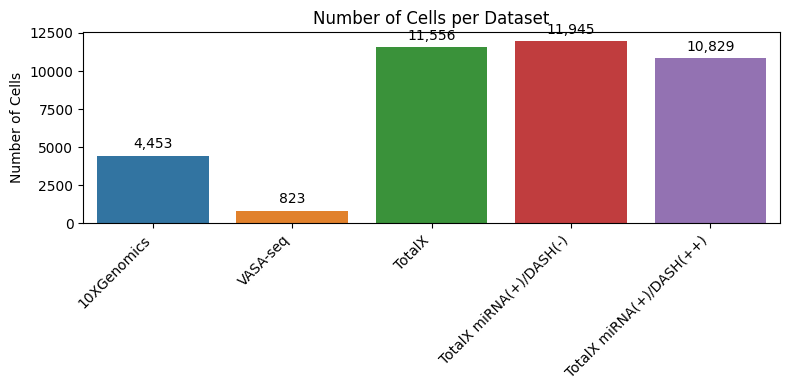

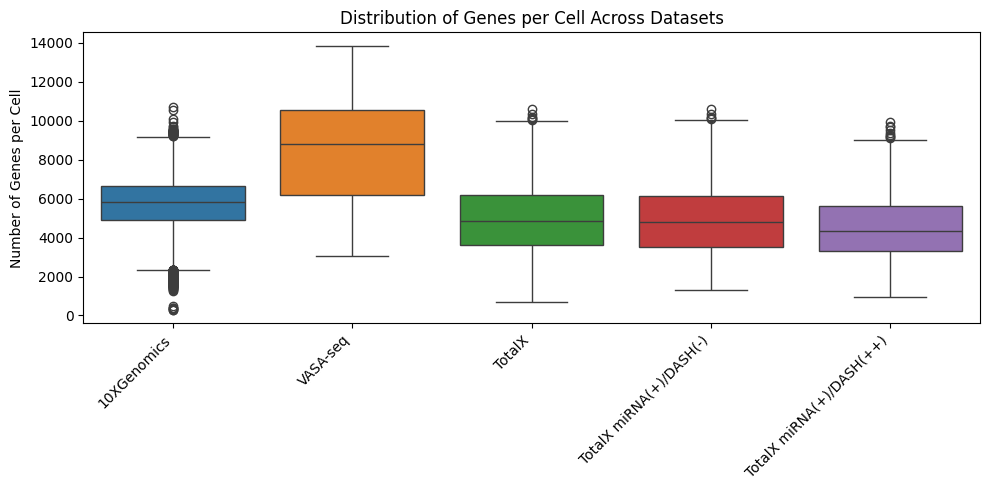

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting
cell_counts = []
genes_per_cell = []

for adata in filtered_adata_list:
    # Number of cells
    cell_counts.append(adata.n_obs)

    # Number of genes expressed per cell (non-zero entries)
    expressed_genes = np.array((adata.X > 0).sum(axis=1)).flatten()
    genes_per_cell.append(expressed_genes)

# Choose a color palette
palette = sns.color_palette("tab10", n_colors=len(titles))

# -----------------------------------
# Plot 1: Barplot with matching colors
plt.figure(figsize=(8, 4))
bars=sns.barplot(x=titles, y=cell_counts, palette=palette)
# Add numbers on top of bars
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 300,  # adjust offset as needed
        f'{int(height):,}',  # format with commas
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Cells")
plt.title("Number of Cells per Dataset")
plt.tight_layout()
plt.show()

# ------------------------------
# Plot 2: Boxplot — number of genes per cell per dataset
plt.figure(figsize=(10, 5))
sns.boxplot(data=genes_per_cell)
plt.xticks(ticks=range(len(titles)), labels=titles, rotation=45, ha='right')
plt.ylabel("Number of Genes per Cell")
plt.title("Distribution of Genes per Cell Across Datasets")
plt.tight_layout()
plt.show()


Compute fraction of UMIs per biotype

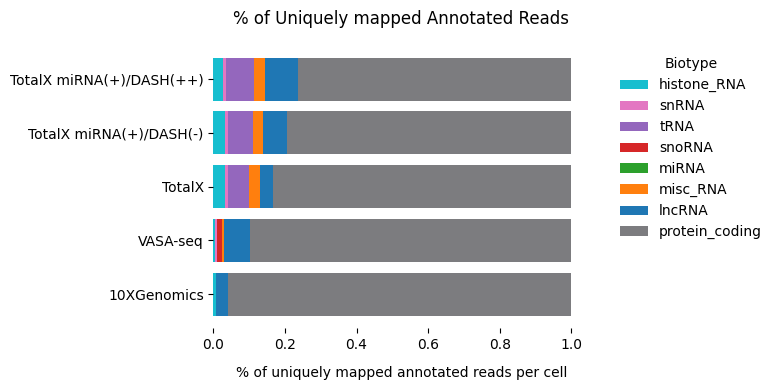

In [6]:
# List of target biotypes (desired order for the y-axis)
target_biotypes = ["protein_coding","lncRNA", "misc_RNA", "miRNA", "snoRNA", "tRNA", "snRNA", "histone_RNA"]
# Reverse the order of target biotypes
reversed_biotypes = target_biotypes[::-1]

biotype_colors = {
    'lncRNA': '#1f77b4',
    'misc_RNA': '#ff7f0e',
    'miRNA': '#2ca02c',
    'snoRNA': '#d62728',
    'tRNA': '#9467bd',
    'scaRNA': '#8c564b',
    'snRNA': '#e377c2',
    'histone_RNA': '#17BECF',
    "protein_coding": '#7c7c7f'
}

# Function to calculate average fraction of UMIs per biotype per dataset
def calculate_umi_fraction_per_biotype(adata, biotype_col='biotype', target_biotypes=None):
    if biotype_col not in adata.var.columns:
        raise ValueError(f"'{biotype_col}' column not found in adata.var")
    
    # Ensure indices are strings
    adata.obs.index = adata.obs.index.astype(str)
    adata.var.index = adata.var.index.astype(str)

    # Filter genes to include only the target biotypes
    if target_biotypes is not None:
        biotype_mask = adata.var[biotype_col].isin(target_biotypes)
        adata_filtered = adata[:, biotype_mask]
    else:
        adata_filtered = adata

    # Create a DataFrame to store UMI sums for each biotype
    biotype_sums = pd.DataFrame(
        {biotype: adata_filtered[:, adata_filtered.var[biotype_col] == biotype].X.sum(axis=1).A1
         if issparse(adata_filtered.X) else
         adata_filtered[:, adata_filtered.var[biotype_col] == biotype].X.sum(axis=1).ravel()
         for biotype in target_biotypes},
        index=adata.obs.index
    )

    # Calculate total UMIs per cell
    total_umis_per_cell = biotype_sums.sum(axis=1)

    # Calculate fraction of UMIs per biotype per cell
    umi_fractions_per_cell = biotype_sums.div(total_umis_per_cell, axis=0)

    # Calculate mean fractions across all cells
    return umi_fractions_per_cell.mean()

# Calculate UMI fractions for all datasets
umi_fractions = {
    title: calculate_umi_fraction_per_biotype(adata, biotype_col='biotype', target_biotypes=target_biotypes)
    for adata, title in zip(adata_list, titles)
}

# Combine results into a DataFrame
umi_fractions_df = pd.DataFrame(umi_fractions)

# Reorder the DataFrame to match the reversed biotypes
umi_fractions_df = umi_fractions_df.reindex(reversed_biotypes)

# Plot horizontal stacked bar chart
plt.figure(figsize=(8, 4))
left_values = np.zeros(len(umi_fractions_df.columns))  # Tracks the left position of each bar segment

for biotype in umi_fractions_df.index:
    plt.barh(
        umi_fractions_df.columns,         # Datasets on the y-axis
        umi_fractions_df.loc[biotype],    # Fraction for the current biotype
        left=left_values,                 # Stack bars horizontally
        label=biotype,  
        color=biotype_colors[biotype],                  # Biotype name for the legend
        edgecolor='none'                  # Removes borders
    )
    left_values += umi_fractions_df.loc[biotype]

# Add labels, legend, and title
plt.title('% of Uniquely mapped Annotated Reads', pad=15)
plt.xlabel('% of Uniquely mapped Annotated Reads', labelpad=10)
plt.legend(title='Biotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)  # Removes legend border

# Remove grid and spines
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xlabel('% of uniquely mapped annotated reads per cell', labelpad=10)
plt.tight_layout()
plt.show()



In [7]:
print("Final umi_fractions_df shape:", umi_fractions_df.shape)
print("Columns:", umi_fractions_df.columns.tolist())
print("Any columns with all NaN values:\n", umi_fractions_df.isna().all())


Final umi_fractions_df shape: (8, 5)
Columns: ['10XGenomics', 'VASA-seq', 'TotalX', 'TotalX miRNA(+)/DASH(-)', 'TotalX miRNA(+)/DASH(++)']
Any columns with all NaN values:
 10XGenomics                 False
VASA-seq                    False
TotalX                      False
TotalX miRNA(+)/DASH(-)     False
TotalX miRNA(+)/DASH(++)    False
dtype: bool


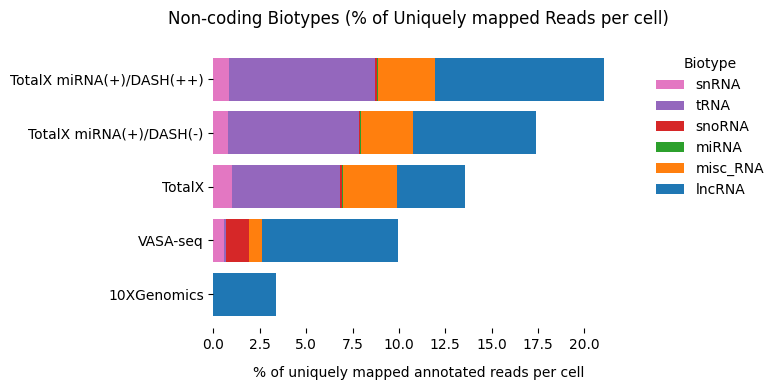

In [8]:
# Exclude 'protein_coding' from plotting (but keep the fractions as originally computed)
biotypes_to_plot = [b for b in umi_fractions_df.index if b not in ['protein_coding', 'histone_RNA']]
plt.figure(figsize=(8, 4))
left_values = np.zeros(len(umi_fractions_df.columns))  # Track left position for stacking

for biotype in biotypes_to_plot:
    plt.barh(
        umi_fractions_df.columns,
        umi_fractions_df.loc[biotype] * 100,  # Convert fraction to percentage
        left=left_values,
        label=biotype,
        color=biotype_colors.get(biotype, '#333333'),
        edgecolor='none'
    )
    left_values += umi_fractions_df.loc[biotype] * 100  # Update left values accordingly


# Add labels, legend, and title
plt.title('Non-coding Biotypes (% of Uniquely mapped Reads per cell)', pad=15)
plt.xlabel('% of uniquely mapped annotated reads per cell', labelpad=10)
plt.legend(title='Biotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Remove grid and spines
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


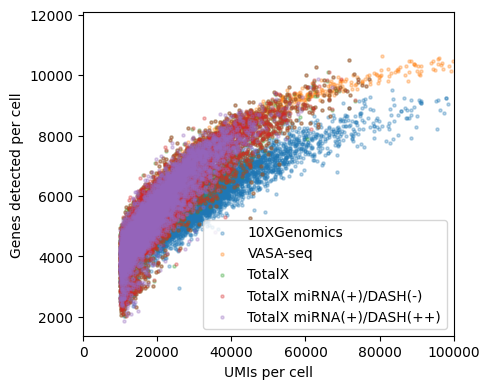

In [9]:
def prepare_unique_genes(adata):
    """
    Clean GeneNames and remove duplicate genes and tRNAs.
    """
    adata.var['GeneName'] = adata.var['GeneName'].str.split('.').str[0]
    #adata = adata[:, ~adata.var['GeneName'].str.contains('tRNA', na=False)].copy()    
    unique_gene_mask = ~adata.var['GeneName'].duplicated(keep=False)
    return adata[:, unique_gene_mask].copy()

plt.figure(figsize=(5, 4))
for adata, title in zip(adata_list, titles):
    adata_unique = prepare_unique_genes(adata)
    adata_unique.obs['n_counts'] = adata_unique.X.sum(axis=1).A1
    adata_unique.obs['n_genes'] = (adata_unique.X > 0).sum(axis=1).A1
    adata_filtered = adata_unique[adata_unique.obs['n_counts'] >= 10000]
    plt.scatter(adata_filtered.obs['n_counts'], adata_filtered.obs['n_genes'], alpha=0.3, label=title, s=5)

plt.xlabel("UMIs per cell")
plt.ylabel("Genes detected per cell")
plt.legend()
plt.xlim(0,100000)
plt.tight_layout()
plt.show()